In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import random
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 10 
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn import preprocessing
from statannot import add_stat_annotation
from scipy import optimize
from sklearn.mixture import GaussianMixture

# Functions

In [2]:
def substract_ini(data_frame):
    
    #supposes already sorted
    out=data_frame.copy(True)
    out['x_s']= pandas.Series(dtype='float64')
    out['y_s']= pandas.Series(dtype='float64')
    
    if 'id' in out.columns:
        for count,part in enumerate(data_frame.id.unique()):
            out.loc[out.id == part,'x_s']= out.loc[out.id == part,'x'] -  out.loc[out.id == part,'x'].iloc[0]
            out.loc[out.id == part,'y_s']= out.loc[out.id == part,'y'] -  out.loc[out.id == part,'y'].iloc[0]
    else:    
        for count,part in enumerate(data_frame.particle.unique()):
            out.loc[out.particle == part,'x_s']= out.loc[out.particle == part,'x'] -  out.loc[out.particle == part,'x'].iloc[0]
            out.loc[out.particle == part,'y_s']= out.loc[out.particle == part,'y'] -  out.loc[out.particle == part,'y'].iloc[0]   
    return out  


def cut_traj(data_cell,deltat):
    
    #cut trajectories in pieces of size deltat
    
    count=0
    for p in data_cell.particle.unique():

        df_cell = data_cell.loc[data_cell.particle==p].copy(True)
        df_cell=df_cell.sort_values('frame')
        
        count_loc=0
        for start in range(0, df_cell.shape[0], deltat):
            df_subset = df_cell.iloc[start:start + deltat]
        
            if(len(df_subset.x.values)>= deltat):
                new_df={'date':df_subset.date.iloc[0] * np.ones(deltat),'well':df_subset.well.iloc[0]  * np.ones(deltat),'particle':p  * np.ones(deltat),'piece':count_loc  * np.ones(deltat),
                                'x':df_subset.x.values,'y':df_subset.y.values,'frame':df_subset.frame.values - df_subset.frame.iloc[0]}
                count_loc+=1
                if(count == 0):
                    out=pandas.DataFrame(new_df)
                    count=1
                else:  
                    out=pandas.concat([out,pandas.DataFrame(new_df)])
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    out['id']=out.groupby(by=['particle','piece']).ngroup()    
    return out     


def cut_traj_overlap(data_cell,deltat):
    
    #cut trajectories in pieces of size deltat, pieces will overlap
    
    delta= int(deltat/2)

    count=0
    for p in data_cell.particle.unique():

        df_cell = data_cell.loc[data_cell.particle==p].copy(True)
        df_cell=df_cell.sort_values('frame')
        
        count_loc=0
        #for start in range(delta, df_cell.shape[0]-delta):
        for start in range(0, df_cell.shape[0]-deltat): 

           # df_subset = df_cell.iloc[start-delta:start + delta]
            df_subset = df_cell.iloc[start:start + deltat]

            if(len(df_subset.x.values)>= deltat):
                
                new_df={'date':df_subset.date.iloc[0] * np.ones(deltat),'well':df_subset.well.iloc[0]  * np.ones(deltat),
                        'particle':p  * np.ones(deltat),'piece':count_loc  * np.ones(deltat),'t': df_subset.frame.iloc[delta],
                                'x':df_subset.x.values,'y':df_subset.y.values,'frame':df_subset.frame.values - df_subset.frame.iloc[0]}
                """
                new_df={'date':df_subset.date.iloc[0] * np.ones(deltat),'well':df_subset.well.iloc[0]  * np.ones(deltat),
                        'particle':p  * np.ones(deltat),'piece':count_loc  * np.ones(deltat),'t': df_subset.frame.iloc[start],
                                'x':df_subset.x.values,'y':df_subset.y.values,'frame':df_subset.frame.values - df_subset.frame.iloc[0]}
                """
                count_loc+=1
                if(count == 0):
                    out=pandas.DataFrame(new_df)
                    count=1
                else:  
                    out=pandas.concat([out,pandas.DataFrame(new_df)])

    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    out['id']=out.groupby(by=['particle','piece']).ngroup()    
    return out



def cut_to_caspase(data_cas,data_cell,deltat):
    # we cut to caspase and only deltat frames before - > cells that don't have that lenghth are thrown out
    # this function is intendet only for trajecotories and not their properties !
    
    count=0.05
    for d in data_cas.date.unique():
        df1=data_cas.loc[data_cas.date == d].copy()
        for w in data_cas.well.unique():
                df_cas = df1.loc[df1.well == w]
    
                #can have several entries because several caspases per well
                count_loc=0
                for foo,row in df_cas.iterrows():
                    count_loc=count_loc+1
                    df_cell = data_cell.loc[(data_cell.well==w) & (data_cell.date == d) ].copy(True)
                    df_cell['time_to_cas_f']=(row.hitting-df_cell.frame.values)

                    df_cell['oI']= ( row.hitting-deltat < df_cell['frame']) & (df_cell['frame']<= row.hitting) 
                    df_cell.oI = df_cell.oI.replace({True: 1, False: 0})

                    for p in df_cell.particle.unique():
                    
                        df=df_cell[(df_cell.particle==p) & (df_cell.oI==1)].sort_values('frame')
                        if(len(df.x.values)>= deltat):
                            new_df={'date':d * np.ones(len(df.x.values)),'well':w  * np.ones(len(df.x.values)),'particle':p  * np.ones(len(df.x.values)),
                                    'id':p  * np.ones(len(df.x.values)),'event':count_loc  * np.ones(len(df.x.values)),
                                    'frame':(row.hitting-df.frame.values),'time': (row.hitting-df.frame.values) *  0.05,
                                'x':df.x.values,'y':df.y.values}

                            if(count == 0):
                                out=pandas.DataFrame(new_df)
                                count=1
                            else:  
                                 out=pandas.concat([out,pandas.DataFrame(new_df)])

    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)

    return out  


def CasFilterProperties(data_cas,data_cell,deltat,radius,threshold_P):
    
    # we cut to caspase and only deltat frames before - > cells that don't have that length are thrown out

    #1) find matching data (date,type and well)
    #3) only take data up to  frames befor hitting 
    #4) note that date and well is not unique since one well can have several not related caspase events
    
    count=0
        
    for d in data_cas.date.unique():
        df1=data_cas.loc[data_cas.date == d].copy()
        for w in data_cas.well.unique():
                df_cas = df1.loc[df1.well == w]
    
                #can have several entries because several caspases per well
                count_loc=0
                for foo,row in df_cas.iterrows():
                    count_loc=count_loc+1
                    df_cell = data_cell.loc[(data_cell.well==w) & (data_cell.date == d) ].copy()
                    #distance to caspase event   
                    df_cell['dist']= np.sqrt( (df_cell.x - row.x) **2  + ( df_cell.y -  row.y)**2 )    
                    df_cell['oIT']= ( row.hitting-deltat < df_cell['frame']) & (df_cell['frame']<= row.hitting) 
                    df_cell['oID']= df_cell['dist']<=radius
                    
                    df_cell['oI']= df_cell['oIT'] &  df_cell['oID']
                    df_cell.oI = df_cell.oI.replace({True: 1, False: 0})
                    
                    for part in df_cell.particle.unique():
                        df=df_cell[df_cell.particle==part]

                        if(df.oI.sum() >=5):#only cells with at least 5 frames
                        
                            new_df={'particle':part,'date':d,'well':w,'event':count_loc,'count_frames':len(df[df.oI==1].P),'frames_P_g': len(df[(df.oI==1) & (df.P < threshold_P)])}
           
    
                            if(count == 0):
                                out=pandas.DataFrame(new_df,index=[0])
                                count=1
                            else:  
                                out=pandas.concat([out,pandas.DataFrame(new_df,index=[0])])             
    return out 

def transform_pca(data_frame,scaler,pca):

        return pca.transform(scaler.transform(data_frame))
        
def compute_radius_of_gyrationEV(data_frame):
    
    # assume data_frame contains different trajectories (x,y values) marked by  a property  called "particle" or if cut into pieces 'id' and identifies as well and date
    # we compute first the  2 d gyration tensor and then its eigenvalues (easy because its a 2x2 symmetric matrix), but we dont really need the eigenvalues independently
    
    if 'id' in data_frame.columns:
        
        
        for count,part in enumerate(data_frame.id.unique()):
            df = data_frame.loc[data_frame.id == part,['x','y']].copy()

            T=df.cov(ddof=0)
            #now Eigenvalues of a symmetric matrix (a b; b d) are:  (a+d)+- sqrt((a-d)^2 + 4 b^2)/2
            #discriminant=np.sqrt((T['x'].x - T['y'].y )**2 + 4 * T['x'].y **2)
            #ev1=(T['x'].x + T['y'].y +  discriminant)/2
            #ev2=(T['x'].x + T['y'].y -  discriminant)/2
            Rg2= T['x'].x + T['y'].y
            asperhity= ((T['x'].x - T['y'].y )**2 + 4 * (T['x'].y **2))/(Rg2**2)

            if 't' in data_frame.columns:
                new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'g':np.sqrt(Rg2),'asp':asperhity,'t':data_frame.loc[data_frame.id == part].t.iloc[0]}

            else:
                new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'g':np.sqrt(Rg2),'asp':asperhity}

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])]) 
    else:
        
        for count,part in enumerate(data_frame.particle.unique()):
            df = data_frame.loc[data_frame.particle == part,['x','y']].copy()

            T=df.cov(ddof=0)
            #now Eigenvalues of a symmetric matrix (a b; b d) are:  (a+d)+- sqrt((a-d)^2 + 4 b^2)/2
            #discriminant=np.sqrt((T['x'].x - T['y'].y )**2 + 4 * T['x'].y **2)
            #ev1=(T['x'].x + T['y'].y +  discriminant)/2
            #ev2=(T['x'].x + T['y'].y -  discriminant)/2
            Rg2= T['x'].x + T['y'].y
            asperhity= ((T['x'].x - T['y'].y )**2 + 4 * (T['x'].y **2))/(Rg2**2)

            new_df={'particle':part,'date':data_frame.loc[data_frame.particle == part].date.iloc[0],'well':data_frame.loc[data_frame.particle == part].well.iloc[0],'g':np.sqrt(Rg2),'asp':asperhity}
            #print(new_df)        

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
            
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out

def compute_kineticEnergy(data_frame):
    
    #assume aldreay sorted by frame
    # assume data_frame contains different trajectories (x,y values) marked by  a property  called "particle" or if cut into pieces 'id' and identifies as well and date
    
    if 'id' in data_frame.columns:
      
        for count,part in enumerate(data_frame.id.unique()):

            df = data_frame.loc[data_frame.id == part]
            if len(df) > 3:
                dx = df.x.diff(1)
                dy = df.y.diff(1)
                dt = 3*df.frame.diff(1)

                vx= (dx/dt).to_numpy()
                vy= (dy/dt).to_numpy()
                v2 = vx**2 + vy**2

            if 't' in data_frame.columns:
                  new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'E':np.nanmean(v2),'t':data_frame.loc[data_frame.id == part].t.iloc[0]}
            else:
                new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'E':np.nanmean(v2)}


            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
    else:
        
        for count,part in enumerate(data_frame.particle.unique()):
            
            df = data_frame.loc[data_frame.particle == part]
            if len(df) > 3:
                dx = df.x.diff(1)
                dy = df.y.diff(1)
                dt = 3*df.frame.diff(1)

                vx= (dx/dt).to_numpy()
                vy= (dy/dt).to_numpy()
                v2 = vx**2 + vy**2

            new_df={'particle':part,'date':data_frame.loc[data_frame.particle == part].date.iloc[0],'well':data_frame.loc[data_frame.particle == part].well.iloc[0],'E':np.nanmean(v2)}

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
   
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out

def compute_end_to_end(data_frame):
    
    # we compute end to end distance but also the straightness as end to end / contour_length
    #assume aldreay sorted by frame
    # assume data_frame contains different trajectories (x,y values) marked by  a property  called "particle" or if cut into pieces 'id' and identifies as well and date
    
    if 'id' in data_frame.columns:
      
        for count,part in enumerate(data_frame.id.unique()):

            df = data_frame.loc[data_frame.id == part]
            dx_end = df.x.iloc[-1] -df.x.iloc[0]
            dy_end =df.y.iloc[-1] -df.y.iloc[0]
            end_to_end=np.sqrt(dx_end**2 + dy_end**2)
                
            dx = df.x.diff(1).to_numpy()
            dy = df.y.diff(1).to_numpy()
                
            dr = np.sqrt(dx[1:]**2 + dy[1:]**2) # this is basically the mean velocity if trajecories all have the same length
            contour_length= np.sum(dr)

            new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'ete':end_to_end,'s': end_to_end/contour_length}

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])

    else:
        
        for count,part in enumerate(data_frame.particle.unique()):

            df = data_frame.loc[data_frame.particle == part]
            dx_end = df.x.iloc[-1] -df.x.iloc[0]
            dy_end =df.y.iloc[-1] -df.y.iloc[0]
            end_to_end=np.sqrt(dx_end**2 + dy_end**2)
                
            dx = df.x.diff(1).to_numpy()
            dy = df.y.diff(1).to_numpy()
                
            dr = np.sqrt(dx[1:]**2 + dy[1:]**2) # this is basically the mean velocity if trajecories all have the same length
            contour_length= np.sum(dr)

            new_df={'particle':part,'date':data_frame.loc[data_frame.particle == part].date.iloc[0],'well':data_frame.loc[data_frame.particle == part].well.iloc[0],
                    'ete':end_to_end,'s': end_to_end/contour_length}

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
            
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out

def compute_time(data_frame):
    
    # we compute length of trajectorie in number of frames
    
    if 'id' in data_frame.columns:
        
      
        for count,part in enumerate(data_frame.id.unique()):

            df = data_frame.loc[data_frame.id == part]
          
            new_df={'id':part,'particle':data_frame.loc[data_frame.id == part].particle.iloc[0],'date':data_frame.loc[data_frame.id == part].date.iloc[0],
                    'well':data_frame.loc[data_frame.id == part].well.iloc[0],'time': df.frame.max()}

            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])

    else:
        
        for count,part in enumerate(data_frame.particle.unique()):

            df = data_frame.loc[data_frame.particle == part]
           
            new_df={'particle':part,'date':data_frame.loc[data_frame.particle == part].date.iloc[0],'well':data_frame.loc[data_frame.particle == part].well.iloc[0],
                    'time': df.frame.max()}


            if(count == 0):
                out=pandas.DataFrame(new_df, index=[0])
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])

            
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out

def compute_run(data_frame,cut=0):
     
    for count,part in enumerate(data_frame.particle.unique()):
        df = data_frame.loc[data_frame.particle == part]        
        zero_crossings = np.where(np.diff(np.sign(cut-df.P.values)))[0]
        
        time_frames=df.frame.values[zero_crossings]
        time_frames=np.insert(time_frames,0, df.frame.iloc[0])

        runs=np.diff(time_frames).astype(np.float32)
        runs=np.insert(runs,0, np.nan)
        
        new_df={'particle':part * np.ones(len(time_frames)),'date':data_frame.loc[data_frame.particle == part].date.iloc[0] * np.ones(len(time_frames)),
                'well':data_frame.loc[data_frame.particle == part].well.iloc[0] * np.ones(len(time_frames)),
                    'runs':runs,'change_frames':time_frames}

        if(count == 0):
            out=pandas.DataFrame(new_df)
        else:  
            out=pandas.concat([out,pandas.DataFrame(new_df)])

            
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out


def compute_run_before_caspase(data_cas,data_cell,deltat,radius,cut=0):
         
    count=0   
    for d in data_cas.date.unique():
        df1=data_cas.loc[data_cas.date == d].copy()
        for w in data_cas.well.unique():
                df_cas = df1.loc[df1.well == w]
    
                #can have several entries because several caspases per well
                count_loc=0
                for foo,row in df_cas.iterrows():
                    count_loc=count_loc+1
                    df_cell = data_cell.loc[(data_cell.well==w) & (data_cell.date == d) ].copy()
                    #distance to caspase event   
                    df_cell['dist']= np.sqrt( (df_cell.x - row.x) **2  + ( df_cell.y -  row.y)**2 )    
                    df_cell['oIT']= ( row.hitting-deltat < df_cell['frame']) & (df_cell['frame']<= row.hitting) 
                    df_cell['oID']= df_cell['dist']<=radius
                    
                    df_cell['oI']= df_cell['oIT'] &  df_cell['oID']
                    df_cell.oI = df_cell.oI.replace({True: 1, False: 0})
                    for part in df_cell.particle.unique():
                        df=df_cell[df_cell.particle==part]

                        if(df.oI.sum() >=5):#only cells with at least 5 frames
                            df_oI= df[df.oI==1].copy()
                            zero_crossings = np.where(np.diff(np.sign(cut-df_oI.P.values)))[0]

                            time_frames=df_oI.frame.values[zero_crossings]
                            time_frames=np.insert(time_frames,0, df_oI.frame.iloc[0])

                            runs=np.diff(time_frames).astype(np.float32)
                            runs=np.insert(runs,0, np.nan)
                            new_df={'particle':part * np.ones(len(time_frames)),'date':d * np.ones(len(time_frames)),
                            'well':w * np.ones(len(time_frames)),'event':count_loc * np.ones(len(time_frames)),'runs':runs,'change_frames':time_frames}
                            
    
                            if(count == 0):
                                out=pandas.DataFrame(new_df)
                                count=1
                            else:  
                                out=pandas.concat([out,pandas.DataFrame(new_df)])

            
    out=out.reset_index() 
    out.drop(columns=['index'],inplace=True)
    return out

# Load data

In [5]:
data_on_spheroid = pandas.read_csv(r'Data\Trajectories_on_spheroids.csv')
tracks_wt_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'wt'].reset_index(drop = True)
tracks_apc_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'apc'].reset_index(drop = True)

# Compute Kinetic energy and Radius of gyration for pieces of trajectories

In [6]:
#sizes of the cuts
cut_time=20

cut_tracks_apc=cut_traj(tracks_apc_spheroid,cut_time)
cut_tracks_wt=cut_traj(tracks_wt_spheroid,cut_time)

cut_tracks_apc=substract_ini(cut_tracks_apc)
cut_tracks_wt=substract_ini(cut_tracks_wt)

#properties of cutted tracks
g_apc= compute_radius_of_gyrationEV(cut_tracks_apc)
g_wt= compute_radius_of_gyrationEV(cut_tracks_wt)

E_apc=compute_kineticEnergy(cut_tracks_apc)
E_wt=compute_kineticEnergy(cut_tracks_wt)

R_apc=compute_end_to_end(cut_tracks_apc)
R_wt=compute_end_to_end(cut_tracks_wt)
np.seterr(divide='ignore', invalid='ignore')
np.seterr(divide='warn', invalid='warn')

prop_apc = g_apc.merge(E_apc, how = 'inner', on = ['date', 'well','particle','id'])
prop_apc = prop_apc.merge(R_apc, how = 'inner', on = ['date', 'well','particle','id'])

prop_wt = g_wt.merge(E_wt,how = 'inner', on = ['date', 'well','particle','id'])
prop_wt = prop_wt.merge(R_wt, how = 'inner', on = ['date', 'well','particle','id'])

prop_wt['type']='wt'
prop_apc['type']='apc'

Energy_gyration  = pandas.concat([prop_wt,prop_apc])
Energy_gyration .dropna(inplace=True)
Energy_gyration =Energy_gyration .reset_index()

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:313: RuntimeWarning: invalid value encountered in double_scalars


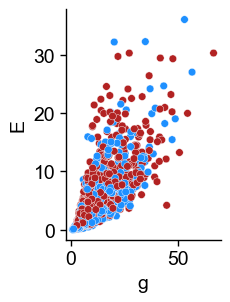

In [7]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2,3))

hue_order = ['apc', 'wt']

# ax.set_ylim(0,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
    
sns.scatterplot(
    x = 'g',
    y = 'E',
    hue = 'type',
    data=Energy_gyration.sample(frac = 1).reset_index(drop=True),
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
    s = 30,
    alpha = 1,
    edgecolors=None,
    linewidth=0.3,
    marker = 'o',
)

ax.set_xlabel('g', fontsize = 14)
ax.set_ylabel('E', fontsize = 14)
ax.get_legend().remove()
plt.show()

# Definition of "EP"

## Perfom PCA and extract information for classification 

In [8]:
data_to_pca=Energy_gyration[['E','g']]
scaler = StandardScaler()
scaler.fit(data_to_pca)
scaled_data = scaler.transform(data_to_pca)
pca = PCA(n_components=2)
pca.fit(scaled_data)
principalComponents=pca.transform(scaled_data)

print('Explained Variance: ', pca.explained_variance_ratio_)

principalDf = pandas.DataFrame(data= principalComponents)
Energy_gyration['P']=principalDf[0]

# Apply a linear transformation to P to make the EP separate the 2 states at EP = 0
Energy_gyration['EP']=-Energy_gyration['P']+0.47373737
Energy_gyration['label']=Energy_gyration['EP']>0

Explained Variance:  [0.87350254 0.12649746]


In [9]:
X=Energy_gyration['EP'].values.reshape(-1, 1)
k = 2
m_init= 1 *np.ones((k,1))
m_init[0]=0
gmm = GaussianMixture(n_components=k,means_init=m_init, random_state = 0).fit(X)

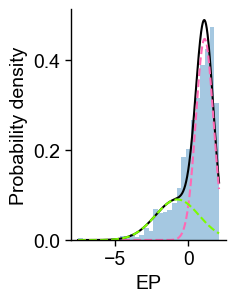

In [10]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2.,3))

# ax.set_ylim(0,60)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

# Compute PDF of whole mixture
x = np.linspace(np.min(X), np.max(X), 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
# Compute PDF for each component
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot data histogram
ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label='Data')
# sns.kdeplot(data=X,c='r',ax=ax)

# Plot PDF of whole model
ax.plot(x, pdf, '-k', label='Mixture PDF')
# Plot PDF of each component
ax.plot(x, pdf_individual[:,0], '--', label='Component PDF', color = 'hotpink')
ax.plot(x, pdf_individual[:,1], '--', label='Component PDF', color = 'lawngreen')

ax.set_xlabel('EP', fontsize = 14)
ax.set_ylabel('Probability density', fontsize = 14)
plt.show()

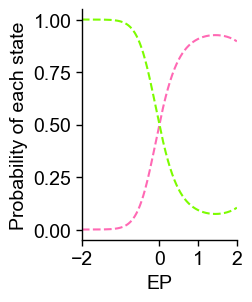

In [11]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2.,3))
ax.set_xlim(-2,2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

x = np.linspace(np.min(X), np.max(X), 10000)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)
# Compute PDF for each component
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    
ax.plot(x, responsibilities[:,0], '--', label='Component PDF', color = 'hotpink')
ax.plot(x, responsibilities[:,1], '--', label='Component PDF', color = 'lawngreen')

ax.set_xticks([-2,0,1,2])    
ax.set_xlabel('EP', fontsize = 14)
ax.set_ylabel('Probability of each state', fontsize = 14)
plt.show()

## Example of pieces of trajectories

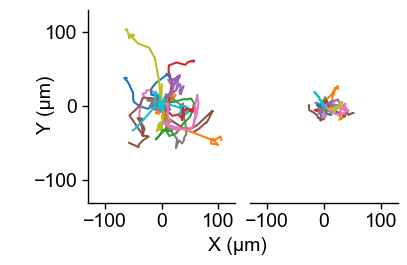

In [23]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1,2, figsize = (4.,2.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in [0,1]:
    ax[i].set_xlim(-130,130)
    ax[i].set_ylim(-130,130)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(True)
    ax[i].tick_params(axis='x', labelsize=14, rotation=0)
    ax[i].tick_params(axis='y', labelsize=14)        
    ax[i].tick_params(width=1, length=4)
    for axis in ['bottom','left']:
        ax[i].spines[axis].set_linewidth(1)
ax[0].spines['left'].set_visible(True)
ax[1].spines['left'].set_visible(False)

# for ids
show=10

for p in random.sample(list(Energy_gyration[(Energy_gyration['label']==0) & (Energy_gyration['type']=='wt')].id.unique()),show):
    ax[0].plot(cut_tracks_wt[cut_tracks_wt.id == p].x_s,cut_tracks_wt[cut_tracks_wt.id == p].y_s)
for p in random.sample(list(Energy_gyration[(Energy_gyration['label']==0) & (Energy_gyration['type']=='apc')].id.unique()),show):
    ax[0].plot(cut_tracks_apc[cut_tracks_apc.id == p].x_s,cut_tracks_apc[cut_tracks_apc.id == p].y_s)

for p in random.sample(list(Energy_gyration[(Energy_gyration['label']==1) & (Energy_gyration['type']=='wt')].id.unique()),show):
    ax[1].plot(cut_tracks_wt[cut_tracks_wt.id == p].x_s,cut_tracks_wt[cut_tracks_wt.id == p].y_s)
for p in random.sample(list(Energy_gyration[(Energy_gyration['label']==1) & (Energy_gyration['type']=='apc')].id.unique()),show):
    ax[1].plot(cut_tracks_apc[cut_tracks_apc.id == p].x_s,cut_tracks_apc[cut_tracks_apc.id == p].y_s)

ax[0].set_ylabel(' ', fontsize=14)
ax[1].set_xlabel(' ', fontsize=14)
ax[1].set_ylabel(' ', fontsize=14)
ax[0].set_xlabel(' ', fontsize=14)

labels = []
ax[1].set_yticklabels(labels, fontsize = 12)
ax[1].set_yticks([])

fig.supxlabel('X (µm)', fontsize = 14, ha = 'center', y = -0.1)
fig.supylabel('Y (µm)', fontsize = 14, ha = 'center')
plt.show()

# Compute EP over the full trajectory

In [13]:
cut_tracks_cont_apc=cut_traj_overlap(tracks_apc_spheroid,20)
cut_tracks_cont_wt=cut_traj_overlap(tracks_wt_spheroid,20)

cut_tracks_cont_apc=substract_ini(cut_tracks_cont_apc)
cut_tracks_cont_wt=substract_ini(cut_tracks_cont_wt)

#properties of cuted tracks: 
g_apc= compute_radius_of_gyrationEV(cut_tracks_cont_apc)
g_wt= compute_radius_of_gyrationEV(cut_tracks_cont_wt)

E_apc=compute_kineticEnergy(cut_tracks_cont_apc)
E_wt=compute_kineticEnergy(cut_tracks_cont_wt)

prop_apc = g_apc.merge(E_apc, how = 'inner', on = ['date', 'well','particle','id','t'])
prop_wt = g_wt.merge(E_wt,how = 'inner', on = ['date', 'well','particle','id','t'])
prop_wt['type']='wt'
prop_apc['type']='apc'

prop_cont =  pandas.concat([prop_wt,prop_apc])
prop_cont.dropna(inplace=True)
prop_cont=prop_cont.reset_index()

data_to_transform=prop_cont[['E','g']]
foo=transform_pca(data_to_transform,scaler,pca)
principalDf_cont = pandas.DataFrame(data= foo)
prop_cont['P']=principalDf_cont[0]
prop_cont=prop_cont.rename(columns={'t':'frame'})

apc_traj = tracks_apc_spheroid.merge(prop_cont[prop_cont.type=='apc'], how = 'inner', on = ['date', 'well','particle','frame'])
wt_traj = tracks_wt_spheroid.merge(prop_cont[prop_cont.type=='wt'], how = 'inner', on = ['date', 'well','particle','frame'])
apc_traj['EP']=-apc_traj['P']+0.47373737
wt_traj['EP']=-wt_traj['P']+0.47373737
wt_traj['pos']=wt_traj['EP'] > 0
apc_traj['pos']=apc_traj['EP'] > 0
wt_traj.pos = wt_traj.pos.replace({True: 1, False: 0})
apc_traj.pos = apc_traj.pos.replace({True: 1, False: 0})

## Plot some examples of trajectories

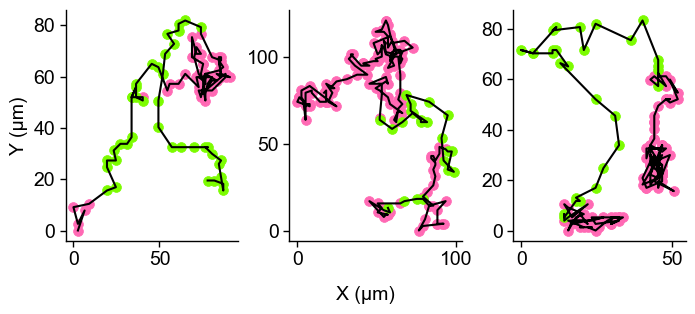

In [15]:
# selectd partice to plot

list_particles = [1,2,4]

# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, 3, figsize = (8,3))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.7)

for i in [0,1,2]:
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(True)
    ax[i].tick_params(axis='x', labelsize=14, rotation=0)
    ax[i].tick_params(axis='y', labelsize=14)        
    ax[i].tick_params(width=1, length=4)
    for axis in ['bottom','left']:
        ax[i].spines[axis].set_linewidth(1)
        
    particle= list_particles[i]
    select=wt_traj[(wt_traj.particle==particle)].copy()
    select_no_nan = select.dropna()
    select_no_nan_part = select_no_nan.loc[select_no_nan.particle == particle]
    time = np.array(select_no_nan_part['frame']*3)
    time = time - np.min(time)
    X = np.array(select_no_nan_part['x'])
    X = X - np.min(X)
    Y = np.array(select_no_nan_part['y'])
    Y = Y - np.min(Y)
    EP = np.array(select_no_nan_part['EP'])

    ax[i].scatter(X[np.where(EP>0)],Y[np.where(EP>0)], linewidths = 0.5, s= 50, c = 'hotpink')
    ax[i].scatter(X[np.where(EP<=0)],Y[np.where(EP<=0)], linewidths = 0.5, s= 50, c = 'lawngreen')
    ax[i].plot(X,Y, c ='k')
ax[0].set_ylabel('Y (µm)', fontsize=14)
ax[0].set_xlabel(' ', fontsize=14)
ax[1].set_ylabel(' ', fontsize = 14)
ax[2].set_ylabel(' ', fontsize = 14)

fig.supxlabel('X (µm)', fontsize = 14, ha = 'center', y = -0.1)

plt.show()

# EP for different number of T cells

In [18]:
Max_Obs_Engagement = pandas.read_csv(r'Data\Fig_S4J.csv')

Count_cells = Max_Obs_Engagement.groupby(['type', 'date', 'well']).apply(lambda x : len(x.particle.unique()))
Count_cells = Count_cells.reset_index()
Count_cells = Count_cells.rename(columns = {0 : 'counts'})

Max_Obs_Engagement['CTLs'] = 0
Max_Obs_Engagement.loc[Max_Obs_Engagement.max_obs_n.isin([1,2,3,4]), 'CTLs'] = '1-4'
Max_Obs_Engagement.loc[Max_Obs_Engagement.max_obs_n.isin([5,6,7,8]), 'CTLs'] = '5-8'

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:38: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 14.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\seaborn\categorical.py:3544: UserWarning: 13.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\vabonnet\AppDat

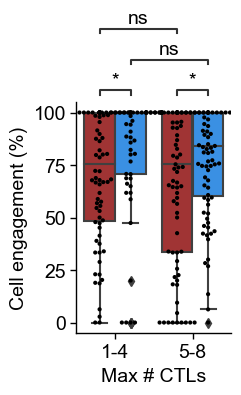

In [19]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

order = ['1-4', '5-8']
hue_order = ['apc', 'wt']
    
sns.boxplot(
    x = 'CTLs',
    y = 'arrest_percent',
    hue = 'type',
    data=Max_Obs_Engagement,
    order = order,
    hue_order = hue_order,
    palette = ['firebrick','dodgerblue'],
)

sns.swarmplot(x = 'CTLs',
              y = 'arrest_percent',
              hue = 'type',
              order = order,
              hue_order = hue_order,
              data=Max_Obs_Engagement,
              size=3,
              palette = ['k'],
              dodge = True)

add_stat_annotation(ax,
    x = 'CTLs',
    y = 'arrest_percent',
    hue = 'type',
    data=Max_Obs_Engagement,
    box_pairs=[(('1-4','apc'), ('1-4','wt')), (('5-8','apc'), ('5-8','wt')), (('1-4','wt'), ('5-8','wt')), (('1-4','apc'), ('5-8','apc'))],
    test='t-test_welch', comparisons_correction=None, 
    fontsize = 14,
    text_format='star', loc='outside', verbose=0)

ax.set_xlabel('Max # CTLs', fontsize = 14)
ax.set_ylabel(r'Cell engagement (%)', fontsize = 14)
ax.get_legend().remove()
plt.show()